This notebook investigates to what extent "clouds" close the budget for certain relevant variables such as liquid water, mass flux etc. "Clouds" are decomposed with two different thresholds: initially simply by considering all points containing liquid water and then a threshold which includes both liquid water and vertical velocity (updraft). 

The idea is is similar to the work done by Siebesma & Cuijpers (1994) who discovered that "estimates of turbulent fluxes by bulk cloud updrafts and environmental downdrafts give an underestimation of 20% to 50% depending on the variable that is transported" 

Here, I use the data from the RICO simulation to calculate the total variable and then compare it to the result from the cloudtracking algorithm, initally for liquid water. 

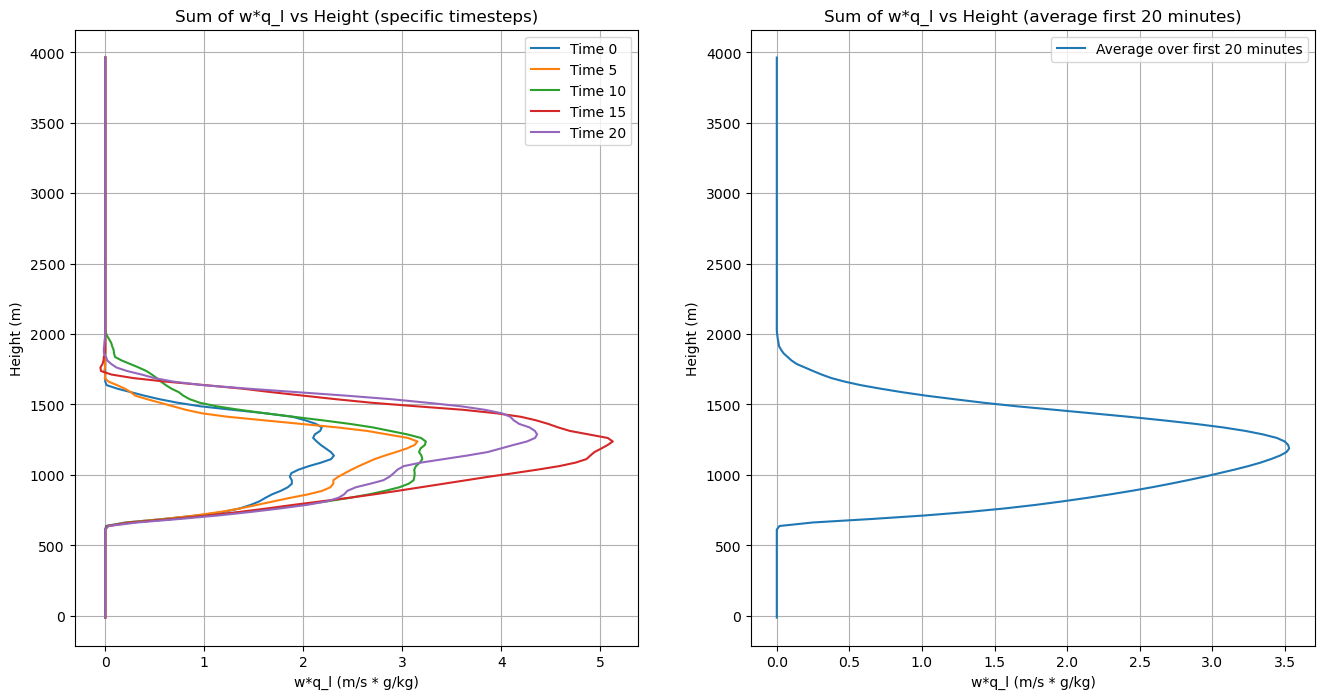

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import os

# Paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

# Load zt values from the liquid water file
zt_values = load_zt_values(l_file)

timesteps = [0, 5, 10,15, 20]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot for specific timesteps
for timestep in timesteps:
    w_data = load_data_all_levels(w_file, 'w', timestep)
    l_data = load_data_all_levels(l_file, 'l', timestep)
    
    product_data = w_data * l_data
    product_means = np.sum(product_data, axis=(1, 2))  # Sum over both horizontal dimensions
    
    axs[0].plot(product_means, zt_values, label=f'Time {timestep}')

axs[0].set_xlabel('w*q_l (m/s * g/kg)')
axs[0].set_ylabel('Height (m)')
axs[0].set_title('Sum of w*q_l vs Height (specific timesteps)')
axs[0].grid(True)
axs[0].legend()

# Averaging over the first 20 minutes
end_timestep = 20
sum_product_data = None

for timestep in range(end_timestep):
    w_data = load_data_all_levels(w_file, 'w', timestep)
    l_data = load_data_all_levels(l_file, 'l', timestep)
    
    product_data = w_data * l_data
    if sum_product_data is None:
        sum_product_data = product_data
    else:
        sum_product_data += product_data

average_product_data = sum_product_data / end_timestep
average_product_means = np.sum(average_product_data, axis=(1, 2))

axs[1].plot(average_product_means, zt_values, label='Average over first 20 minutes')
axs[1].set_xlabel('w*q_l (m/s * g/kg)')
axs[1].set_ylabel('Height (m)')
axs[1].set_title('Sum of w*q_l vs Height (average first 20 minutes)')
axs[1].grid(True)
axs[1].legend()

In [2]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import os

# Paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'

# Thresholds
liquid_water_threshold = 0.0001
vertical_velocity_threshold = 0.0

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

In [3]:
# Load zt values from the liquid water file
zt_values = load_zt_values(l_file)

# Averaging over the first 20 minutes
end_timestep = 10
sum_product_data = None
sum_product_data_l_threshold = None
sum_product_data_wl_threshold = None

for timestep in range(end_timestep):
    w_data = load_data_all_levels(w_file, 'w', timestep)
    l_data = load_data_all_levels(l_file, 'l', timestep)
    
    product_data = w_data * l_data
    product_data_l_threshold = np.where(l_data > liquid_water_threshold, w_data * l_data, 0)
    product_data_wl_threshold = np.where((l_data > liquid_water_threshold) & (w_data > vertical_velocity_threshold), w_data * l_data, 0)

    if sum_product_data is None:
        sum_product_data = product_data
        sum_product_data_l_threshold = product_data_l_threshold
        sum_product_data_wl_threshold = product_data_wl_threshold
    else:
        sum_product_data += product_data
        sum_product_data_l_threshold += product_data_l_threshold
        sum_product_data_wl_threshold += product_data_wl_threshold

average_product_data = sum_product_data / end_timestep
average_product_means = np.sum(average_product_data, axis=(1, 2))

average_product_data_l_threshold = sum_product_data_l_threshold / end_timestep
average_product_means_l_threshold = np.sum(average_product_data_l_threshold, axis=(1, 2))

average_product_data_wl_threshold = sum_product_data_wl_threshold / end_timestep
average_product_means_wl_threshold = np.sum(average_product_data_wl_threshold, axis=(1, 2))


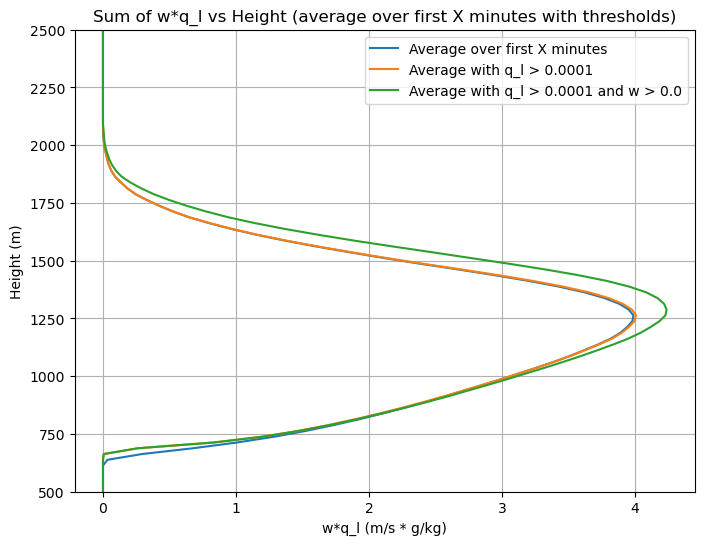

In [4]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(average_product_means, zt_values, label='Average over first X minutes')
ax.plot(average_product_means_l_threshold, zt_values, label=f'Average with q_l > {liquid_water_threshold}')
ax.plot(average_product_means_wl_threshold, zt_values, label=f'Average with q_l > {liquid_water_threshold} and w > {vertical_velocity_threshold}')

ax.set_xlabel('w*q_l (m/s * g/kg)')
ax.set_ylabel('Height (m)')
ax.set_title('Sum of w*q_l vs Height (average over first X minutes with thresholds)')
ax.set_ylim([500,2500])
ax.grid(True)
ax.legend()
plt.show()

# Turbulent flux definition

Deciding on how to best calculate $\big(\overline{w'\phi'}\big)$. Siebesma uses: 

$$\large \big(\overline{w'\phi'}\big) = a {\overline{w'\phi'}}^c  + (1-a) {\overline{w'\phi'}}^e + a(1-a)(w_c-w_e)(\phi_c-\phi_e)$$

where $a$ is the fraction of the active cloud park and $c$ and $e$ denote active cloud and passive environmental averages. The overbar denotes the average over the horizontal level of the model and prime denotes the deviation from the horizontal level average.

Siebesma continues that in mass flux parameterisation schemes, it is assumed that organised turbulence term is dominant, so that

$$\large \big(\overline{w'\phi'}\big) = a(1-a)(w_c-w_e)(\phi_c-\phi_e = \frac{M}{\rho}(\phi_c - \phi_e)$$

where $M$ is defined as a convective mass transport and $\rho$ is density. 


## Fractional definition

Using this definition to start: 
$$\large \big(\overline{w'\phi'}\big) = a(1-a)(w_c-w_e)(\phi_c-\phi_e$$

/Users/jure/opt/miniconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:65: UserWarning: Warning: converting a masked element to nan.
  ary = asanyarray(ary)


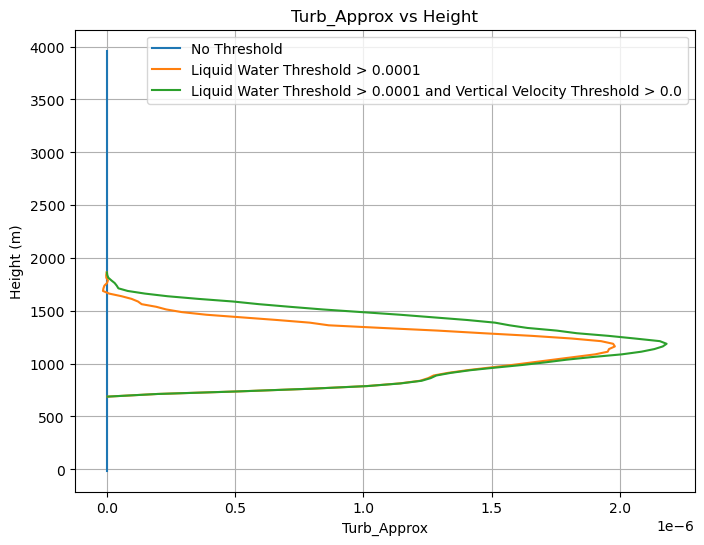

In [6]:
# Paths
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'

# Thresholds
liquid_water_threshold = 0.0001
vertical_velocity_threshold = 0.0

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

# Load zt values from the liquid water file
zt_values = load_zt_values(l_file)

# Averaging over the first 20 minutes
end_timestep = 5
w_sum_data = None
l_sum_data = None
cloudy_points = None
non_cloudy_points = None

for timestep in range(end_timestep):
    w_data = load_data_all_levels(w_file, 'w', timestep)
    l_data = load_data_all_levels(l_file, 'l', timestep)
    
    if w_sum_data is None:
        w_sum_data = w_data
        l_sum_data = l_data
        cloudy_points = np.where((l_data > liquid_water_threshold) & (w_data > vertical_velocity_threshold), 1, 0)
        non_cloudy_points = np.where((l_data <= liquid_water_threshold) | (w_data <= vertical_velocity_threshold), 1, 0)
    else:
        w_sum_data += w_data
        l_sum_data += l_data
        cloudy_points += np.where((l_data > liquid_water_threshold) & (w_data > vertical_velocity_threshold), 1, 0)
        non_cloudy_points += np.where((l_data <= liquid_water_threshold) | (w_data <= vertical_velocity_threshold), 1, 0)

average_w_data = w_sum_data / end_timestep
average_l_data = l_sum_data / end_timestep
fraction_cloudy = cloudy_points / end_timestep

turb_approx_no_threshold = []
turb_approx_liquid_threshold = []
turb_approx_both_thresholds = []

for z in range(average_w_data.shape[0]):
    w_mean = np.mean(average_w_data[z, :, :])
    q_mean = np.mean(average_l_data[z, :, :])
    
    mask_cloudy = (average_l_data[z, :, :] > liquid_water_threshold)
    mask_both = (average_l_data[z, :, :] > liquid_water_threshold) & (average_w_data[z, :, :] > vertical_velocity_threshold)
    
    w_c = np.mean(average_w_data[z, :, :][mask_cloudy])
    w_e = np.mean(average_w_data[z, :, :][~mask_cloudy])
    q_c = np.mean(average_l_data[z, :, :][mask_cloudy])
    q_e = np.mean(average_l_data[z, :, :][~mask_cloudy])
    a = np.mean(mask_cloudy)
    turb_approx_liquid_threshold.append(a * (1 - a) * (w_c - w_e) * (q_c - q_e))
    
    w_c_both = np.mean(average_w_data[z, :, :][mask_both])
    w_e_both = np.mean(average_w_data[z, :, :][~mask_both])
    q_c_both = np.mean(average_l_data[z, :, :][mask_both])
    q_e_both = np.mean(average_l_data[z, :, :][~mask_both])
    a_both = np.mean(mask_both)
    turb_approx_both_thresholds.append(a_both * (1 - a_both) * (w_c_both - w_e_both) * (q_c_both - q_e_both))
    
    turb_approx_no_threshold.append(0)  # Placeholder for no threshold

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(turb_approx_no_threshold, zt_values, label='No Threshold')
ax.plot(turb_approx_liquid_threshold, zt_values, label=f'Liquid Water Threshold > {liquid_water_threshold}')
ax.plot(turb_approx_both_thresholds, zt_values, label=f'Liquid Water Threshold > {liquid_water_threshold} and Vertical Velocity Threshold > {vertical_velocity_threshold}')

ax.set_xlabel('Turb_Approx')
ax.set_ylabel('Height (m)')
ax.set_title('Turb_Approx vs Height')
ax.grid(True)
ax.legend()

output_dir = 'analysis_plots'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, 'turb_approx_thresholds.pdf'), format='pdf', bbox_inches='tight')
plt.show()


## Mass flux definition
Using the definition that includes mass flux

$$\large \big(\overline{w'\phi'}\big) =  \frac{M}{\rho}(\phi_c - \phi_e)$$

requires the calculation of mass flux. 